In [1]:
import glob
import numpy as np
import xarray as xr
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt

from leakage import S1DopplerLeakage
from leakage.low_pass_filter import low_pass_filter_2D

func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.nanmean(x**2)), rounding)
dB = lambda x: 10*np.log10(x)

plt.rcParams.update({'font.size': 10, 'font.weight' : 'bold'})

### 1 - Input where data is stored 

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
era5_dir = "../data/leakage/era5_winds/"
scenario = 'Azores_20201127'

scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [scenario for scenario in scenarios if "_" != scenario[0] ] 

files = glob.glob(f"{data_dir+scenario}/*.SAFE")
files

['/Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/S1B_IW_GRDH_1SDV_20201127T193925_20201127T193950_024455_02E82D_CA05.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/S1B_IW_GRDH_1SDV_20201127T193806_20201127T193835_024455_02E82D_E23C.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/S1B_IW_GRDH_1SDV_20201127T193900_20201127T193925_024455_02E82D_A07B.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/S1B_IW_GRDH_1SDV_20201127T193950_20201127T194015_024455_02E82D_B01D.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/S1B_IW_GRDH_1SDV_20201127T193835_20201127T193900_024455_02E82D_CE1B.SAFE']

### 2 - Prepare analysis

In [3]:
analysis = S1DopplerLeakage(
    filename=files,
    f0=5_400_000_000,
    z0 = 823_000,
    era5_directory=era5_dir,
    resolution_product=50_000,
    az_footprint_cutoff=80_000,
    vx_sat=6_800,
    PRF=4,
    grid_spacing=75,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'phased_array', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=35,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = 1,
    product_averaging_window='hann',
    # _pulsepair_noise = True
    # _speckle_noise= True
    )

/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:184: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn(


### 3 - Perform analysis

In [4]:
analysis.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../data/leakage/era5_winds/era5_wind_202011.nc


### 4 - Modify the coordinates to be in kilometers so that original Sentinel-1 file and computed scatterometer can be plotted on same axis
#### (purely aesthetic)

In [5]:
km2m = 1000

data_plot = analysis.data
data_plot = data_plot.assign_coords(slow_time=data_plot.slow_time/km2m, grg = data_plot.grg/km2m)

grg_average = analysis.S1_file.ground_range_approx.mean(dim = 'line') / km2m
hor_max = grg_average.max().values
hor_min = grg_average.min().values
az_new = np.arange(analysis.S1_file.sigma0.sizes['line']) * analysis.grid_spacing / km2m
grg_new = np.linspace(hor_min, hor_max, analysis.S1_file.sigma0.sizes['sample'])

original_S1 = analysis.S1_file.drop_vars('pol').assign_coords(line=('line', az_new), sample = ('sample', grg_new))

### 5 - estimate residual leakage (and average to product resolution), convert NRCS to dB

In [6]:
fs_x = 1/analysis.grid_spacing
fs_y = 1/analysis.stride

residual_leakage = low_pass_filter_2D(data_plot.V_leakage_pulse_rg-data_plot.V_leakage_pulse_rg_inverted,
                   cutoff_frequency= 1/analysis.resolution_product,
                    fs_x=fs_x,
                    fs_y=fs_y,
                    fill_nans = True)

nrcs_original = dB(original_S1.sigma0)
nrcs_scat = dB(original_S1.sigma0_scat)

### 6 - plot results

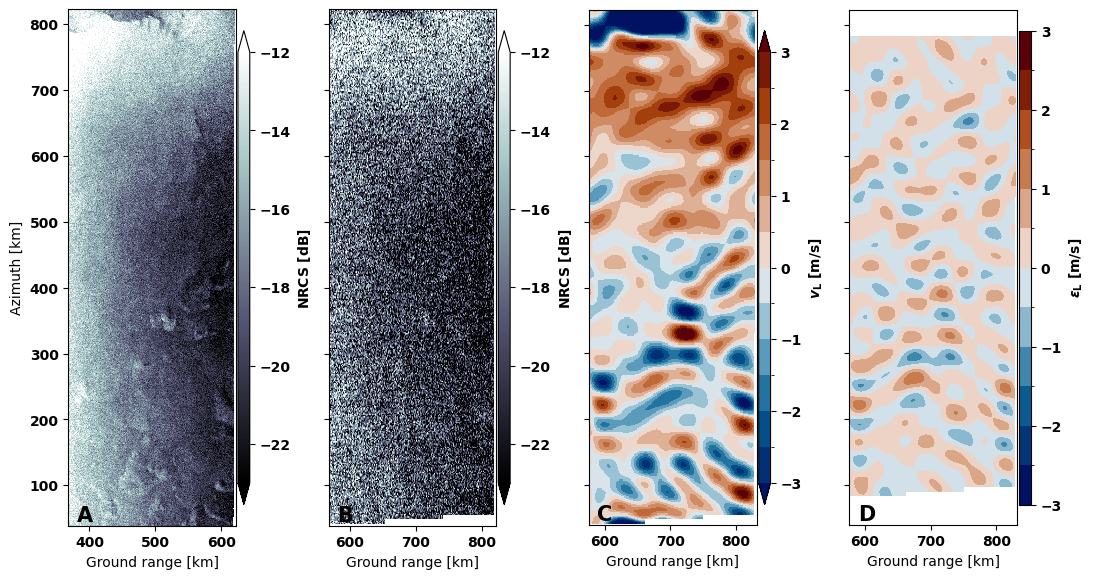

In [7]:
cbar_kwargs = {'shrink':0.9, 'aspect':40, 'pad' : 0.01, 'extend':'both'}
plot_kwargs = {'robust': True}
plot_kwargs_nrcs = {'vmin': -23, 'vmax':-12}

vmin = 3
plot_leakage_kwargs = {'vmin': -vmin, 'vmax': vmin, 'cmap' : cmc.vik, 'levels' : 13}
plot_leakage_net_kwargs = {'vmin': -vmin, 'vmax': vmin, 'cmap' : cmc.vik, 'levels' : 13}# {'vmin': -1, 'vmax': 1, 'cmap' : cmc.bam_r, 'levels' : 9}

nx = 4; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (11, 6), sharex=False, sharey=True)
axes_indexes = np.argwhere(axes)


nrcs_original.plot(ax= axes[*axes_indexes[0]], 
                   **{'cmap': 'bone', **plot_kwargs_nrcs},
                   cbar_kwargs = {'label':r'$\mathrm{NRCS\ [dB]}$', **cbar_kwargs})

nrcs_scat.plot(ax= axes[*axes_indexes[1]], 
                   **{'cmap': 'bone', **plot_kwargs_nrcs},
                   cbar_kwargs = {'label':r'$\mathrm{NRCS\ [dB]}$', **cbar_kwargs})

(data_plot.V_leakage_pulse_rg_subscene).T.plot(ax= axes[*axes_indexes[2]],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':r'$v_{\mathrm{L}}\ \mathrm{[m/s]}$', 'extend':'both', **cbar_kwargs})

residual_leakage.T.plot.contourf(ax= axes[*axes_indexes[3]],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':r'$\epsilon_{\mathrm{L}}\ \mathrm{[m/s]}$', 'extend':'both', **cbar_kwargs})

# Ugly way if fixing the axes of the second plot, which is purely illustrative
axes[*axes_indexes[1]].set_xticks([400, 500, 600])
axes[*axes_indexes[1]].set_xticklabels([600, 700, 800])

x_labels = ['Ground range [km]'] * 4
y_labels = (['Azimuth [km]'] + [''] * (nx - 1)) * ny

_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]
_ = [ax.axes.get_xaxis().get_offset_text().set_position((1.2,-40)) for ax in axes.ravel()]
labels = [i.upper() for i in ['a', 'b', 'c', 'd']]
_ = [ax.text(0.05, 0.04, label, fontsize=15, transform=ax.transAxes, va='top') for ax, label in zip(axes.ravel(), labels)]

plt.tight_layout()

### 7 - Some numbers

In [27]:
# This ensures number are only calculated over the shared portion of the image (net leakage is cropped w.r.t. original leakage)
crop = analysis.data.V_leakage_pulse_rg_subscene_inverted / analysis.data.V_leakage_pulse_rg_subscene_inverted

sigma_v_total = func_rmse(analysis.data.V_sigma_subscene*crop)
sigma_v_leakage = func_rmse(analysis.data.V_leakage_pulse_rg_subscene*crop)
sigma_v_leakage_after_correction = func_rmse(residual_leakage)

pulse_pair_noise = analysis.data.V_sigma - analysis.data.V_leakage_pulse_rg
net_velocity_error =  analysis.data.V_sigma - analysis.data.V_leakage_pulse_rg_inverted


pulse_pair_noise_product_res = low_pass_filter_2D(pulse_pair_noise, 
                       cutoff_frequency= 1/analysis.resolution_product,
                       fs_x=fs_x,
                       fs_y=fs_y,
                       fill_nans = True)
net_velocity_error_product_res = low_pass_filter_2D(net_velocity_error, 
                       cutoff_frequency= 1/analysis.resolution_product,
                       fs_x=fs_x,
                       fs_y=fs_y,
                       fill_nans = True)

sigma_v_pulse_pair = func_rmse(pulse_pair_noise_product_res*crop)
sigma_v_after_correction = func_rmse(net_velocity_error_product_res)

In [29]:
print(f"total velocity uncertainty: {sigma_v_total} m/s \n")
print(f"pulse-pair uncertainty: {sigma_v_pulse_pair} m/s \n")
print(f"leakage uncertainty: {sigma_v_leakage} m/s \n")
print(f"leakage uncertainty after correction for leakage: {sigma_v_leakage_after_correction} m/s \n")
print(f"total uncertainty after correction for leakage: {sigma_v_after_correction} m/s \n")

total velocity uncertainty: 2.403 m/s 

pulse-pair uncertainty: 2.121 m/s 

leakage uncertainty: 1.204 m/s 

leakage uncertainty after correction for leakage: 0.382 m/s 

total uncertainty after correction for leakage: 2.182 m/s 

